# **1. Import Libraries**


In [185]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


# import warnings
import warnings
# ignore warnings
warnings.filterwarnings("ignore")

# **2. Understanding the dataset**
### Read the data in csv file into 'data' variable

In [142]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [144]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")



## Print the first five rows from the dataset

In [145]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Calculate the number of null values in every features in the dataset

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [147]:
df.isna().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


## only bmi variable contains missing values in the entire dataset.

We will look at the simplest ways of dealing with missing values in the dataset.

Delete those rows that contains missing values. But this would not be efficient in our case as our dataset itself is not too big.
Imputation techniques such as filling the null values of bmi with its mean is a good choice when the dataset does not contain outliers. Otherwise replacing the null values with its median would be a good choice.

In [148]:
bmi_missing_values = df['bmi'].isna().value_counts()
print(f'{round(bmi_missing_values[1]/(bmi_missing_values[0] + bmi_missing_values[1])*100,3)} % of bmi data is missing')

3.933 % of bmi data is missing


In [149]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

## id column is not going to help anywhere in the analysis so will delete that column.



In [150]:
df.drop(['id'], axis = 1, inplace = True)

##Now we will look at the outliers in bmi dataset.

Q1 means the value below which 25% of the data falls. Q3 means the value below which 75% of the data falls. IQR means the range between Q1 and Q3, calculated as IQR=Q3−Q1.

We consider any point to be an outlier if it is less than (Q1 - 1.5 IQR) and more than (Q3 + 1.5 IQR).

Bmi has 110 outliers


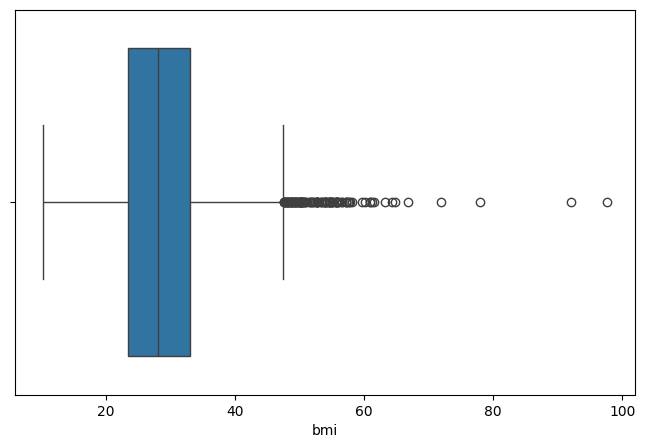

In [151]:
plt.figure(figsize = (8,5))
sns.boxplot(x = df.bmi)
#check for outliers
IQR = df.describe().loc['75%','bmi'] - df.describe().loc['25%','bmi']
lower_limit = df.describe().loc['25%','bmi'] - 1.5*IQR
higher_limit = df.describe().loc['75%','bmi'] + 1.5*IQR
outliers = [val for val in df.bmi if (val < lower_limit or val > higher_limit)]
print("bmi doesn't have any outliers") if len(outliers) == 0 else print(f'Bmi has {len(outliers)} outliers')

From above analysis we can see Bmi has some outliers so mean would not be a good idea. We will replace the null values of Bmi with its median.



In [152]:
median = df['bmi'].median()
df['bmi'] = df['bmi'].fillna(median)

Check if the data still has missing values.



In [153]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


Now no column contains missing values.



#4. Analysing each variable
Now we will analyse each variable independently and understand them.

##Analysing gender
gender is a categorical feature with 3 values "Male", "Female" or "Other"

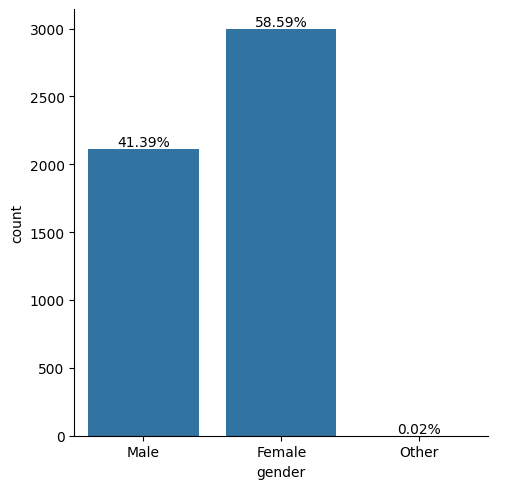

In [154]:
gender_counts = df.gender.value_counts()
total = len(df)

# Create the count plot
plot = sns.catplot(data=df, x="gender", kind="count")
ax = plot.ax

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

From above analysis and visualisations we are certain that dataset contains more females than males.

##Analysing age
age is a numerical variable.

age doesn't have any outliers


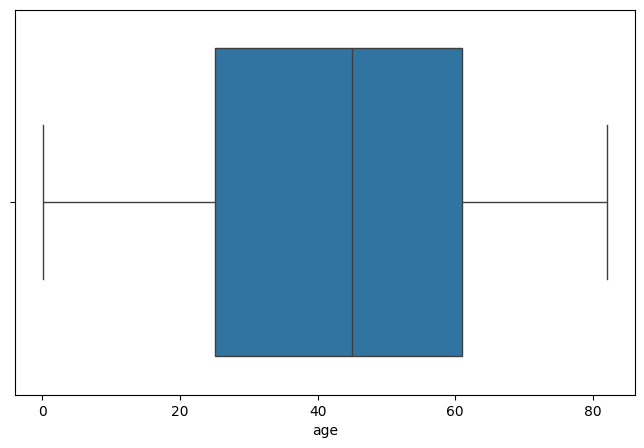

In [155]:
plt.figure(figsize = (8,5))
sns.boxplot(x = df.age)
#check for outliers
IQR = df.describe().loc['75%','age'] - df.describe().loc['25%','age']
lower_limit = df.describe().loc['25%','age'] - 1.5*IQR
higher_limit = df.describe().loc['75%','age'] + 1.5*IQR
outliers = [val for val in df.age if (val < lower_limit or val > higher_limit)]
if len(outliers) == 0 : print("age doesn't have any outliers")

age doesn't have any outliers


Above analysis and boxplot shows that there are no outliers in the age variable. **Age has a median value of 45 yrs.**



<Axes: xlabel='age', ylabel='Count'>

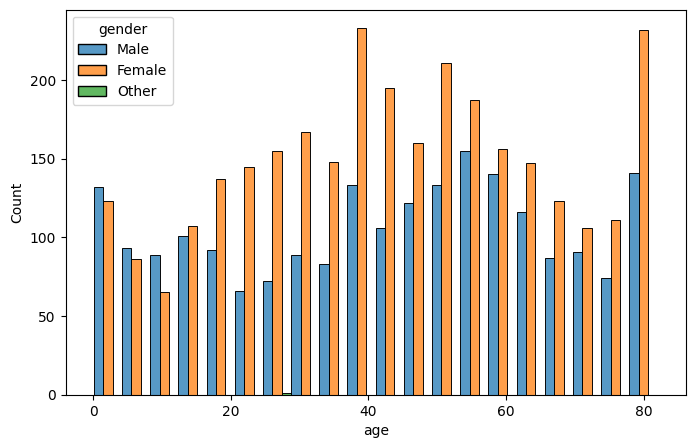

In [156]:
plt.figure(figsize = (8,5))
sns.histplot(data=df, x=df.age, hue=df.gender, multiple="dodge", shrink=1.0)

Clearly, the number of females in the dataset dominate the number of males for ages above 15. For ages below 15 there are more males than females.



##Analysing Hypertension
It is a binary categorical variable 0 if the patient doesn't have hypertension, 1 if the patient has hypertension.

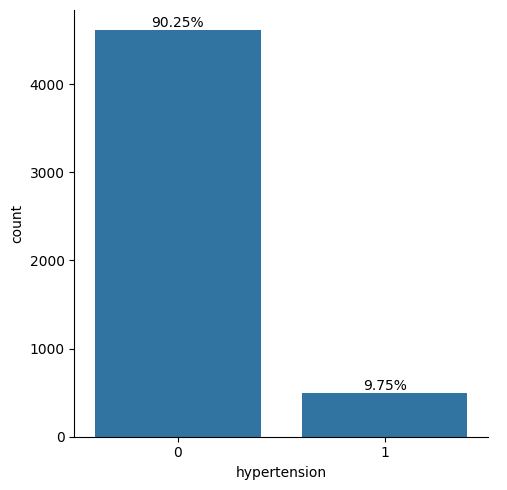

In [157]:
gender_counts = df.hypertension.value_counts()
total = len(df)

# Create the count plot
plot = sns.catplot(data=df, x="hypertension", kind="count")
ax = plot.ax

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

Almost 500 people in the dataset have hypertension.



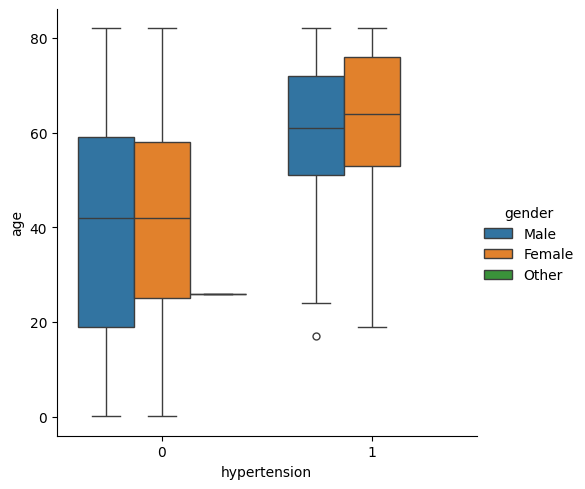

In [158]:
sns.catplot(data=df, x="hypertension", y="age", hue="gender", kind="box")

From above analysis we can conclude that the median age of a male having hypertension is less than that of a female.



##Analysing Heart_disease
It is a binary categorical variable 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

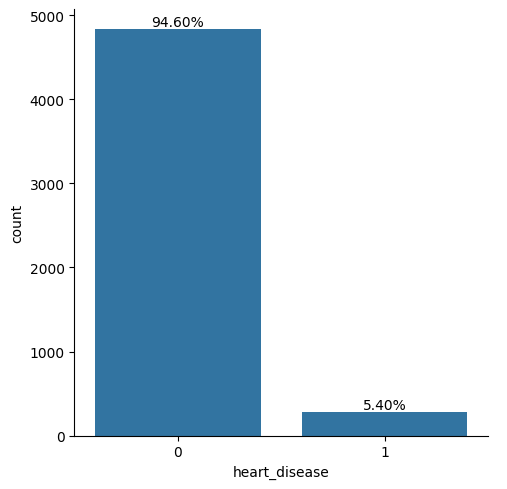

In [159]:
gender_counts = df.heart_disease.value_counts()
total = len(df)

# Create the count plot
plot = sns.catplot(data=df, x="heart_disease", kind="count")
ax = plot.ax

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

Less than 300 people suffers from heart_disease.



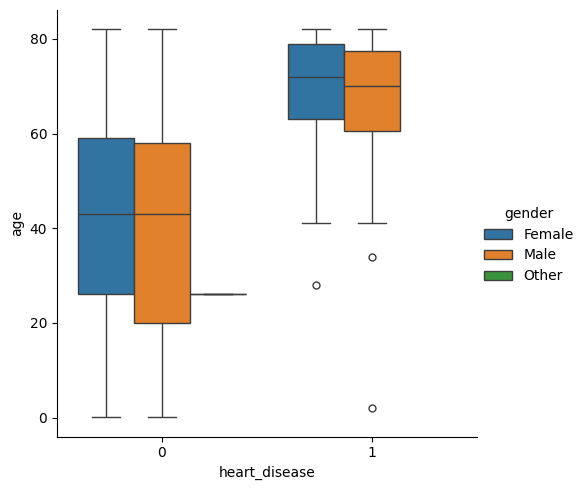

In [160]:
sns.catplot(data=df, x="heart_disease", y="age", hue="gender", kind="box")

From above analysis we can conclude that 50% of the females who sufferes from heart disease are in the age range 72 to 82 years old. Similarily, 50% of males who suffers from heart disease is in the age range 70 to 82 years old.



##Analysing Ever_married
ever_married is a binary categorical variable with values "No" or "Yes"

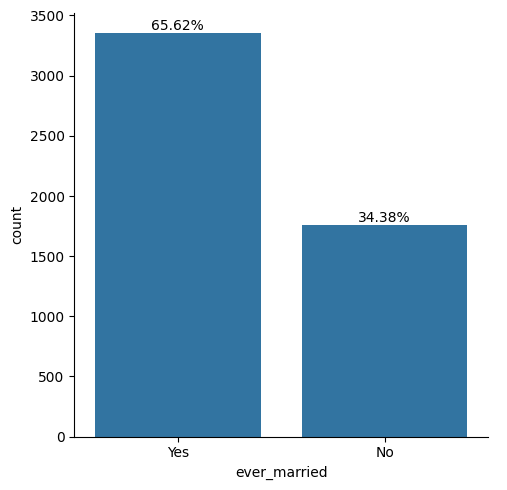

In [161]:
gender_counts = df.ever_married.value_counts()
total = len(df)

# Create the count plot
plot = sns.catplot(data=df, x="ever_married", kind="count")
ax = plot.ax

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

##Analysing Work_type
work_type is a categorical variable with values "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

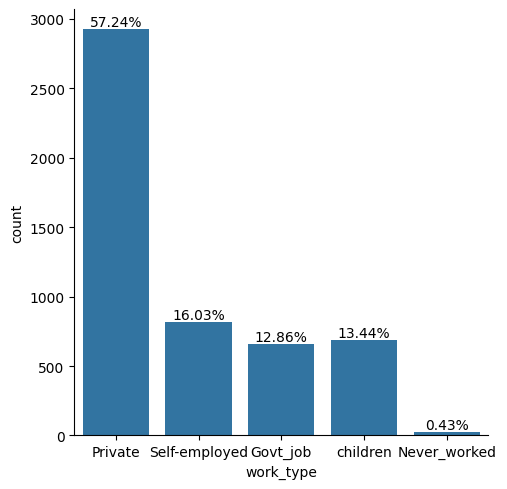

In [162]:
gender_counts = df.work_type.value_counts()
total = len(df)

# Create the count plot
plot = sns.catplot(data=df, x="work_type", kind="count")
ax = plot.ax

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

Largest group of people work in the private sector.



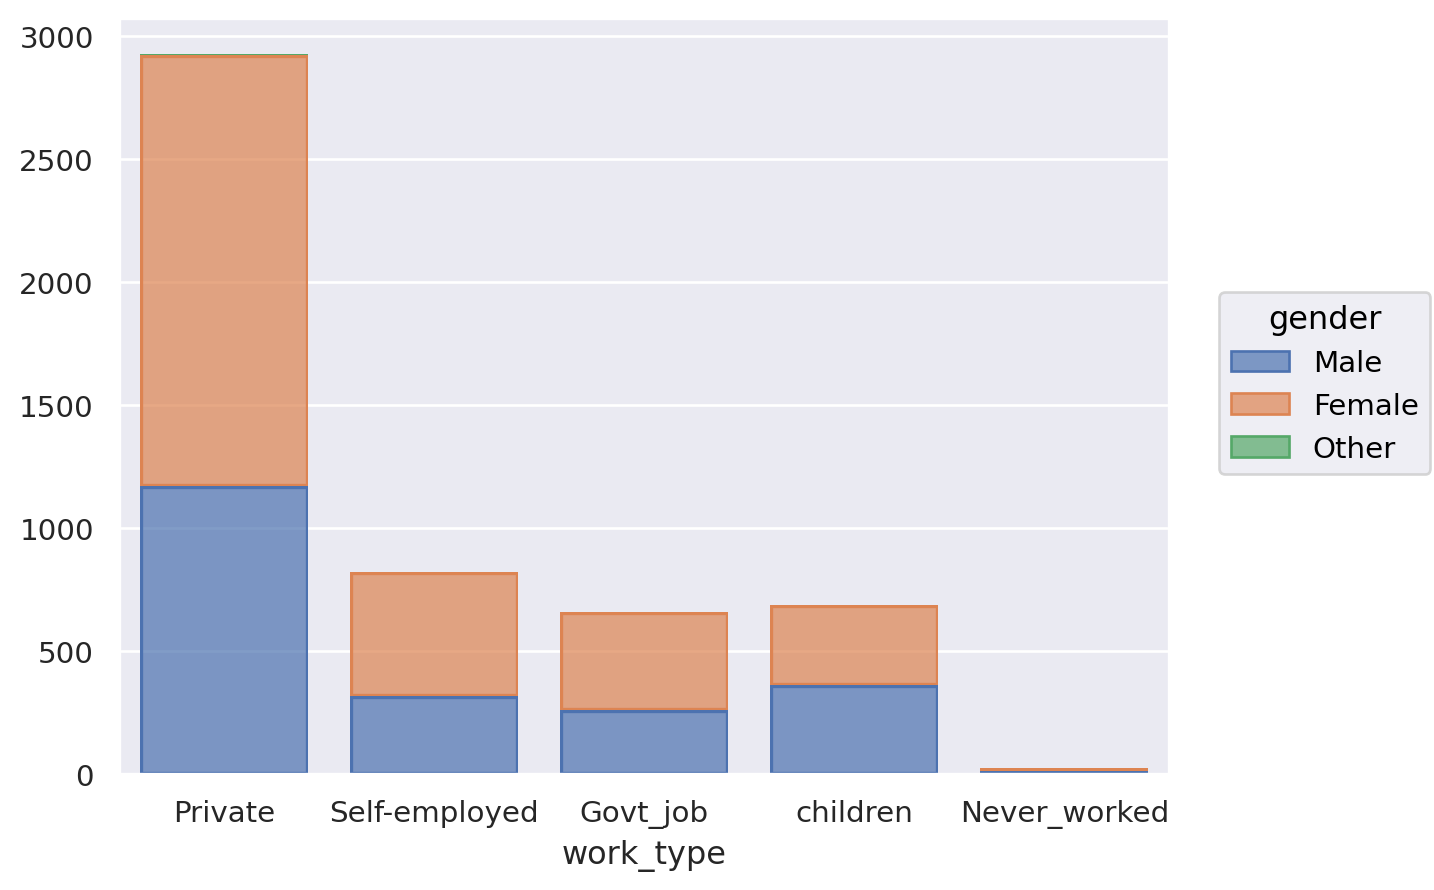

In [163]:
import seaborn.objects as so
so.Plot(df, x="work_type", color="gender").add(so.Bar(), so.Count(), so.Stack())

From above analysis we can see the distribution of males and females in different job sectors.



Let's see if there is any relation in between work_type and heart_disease.



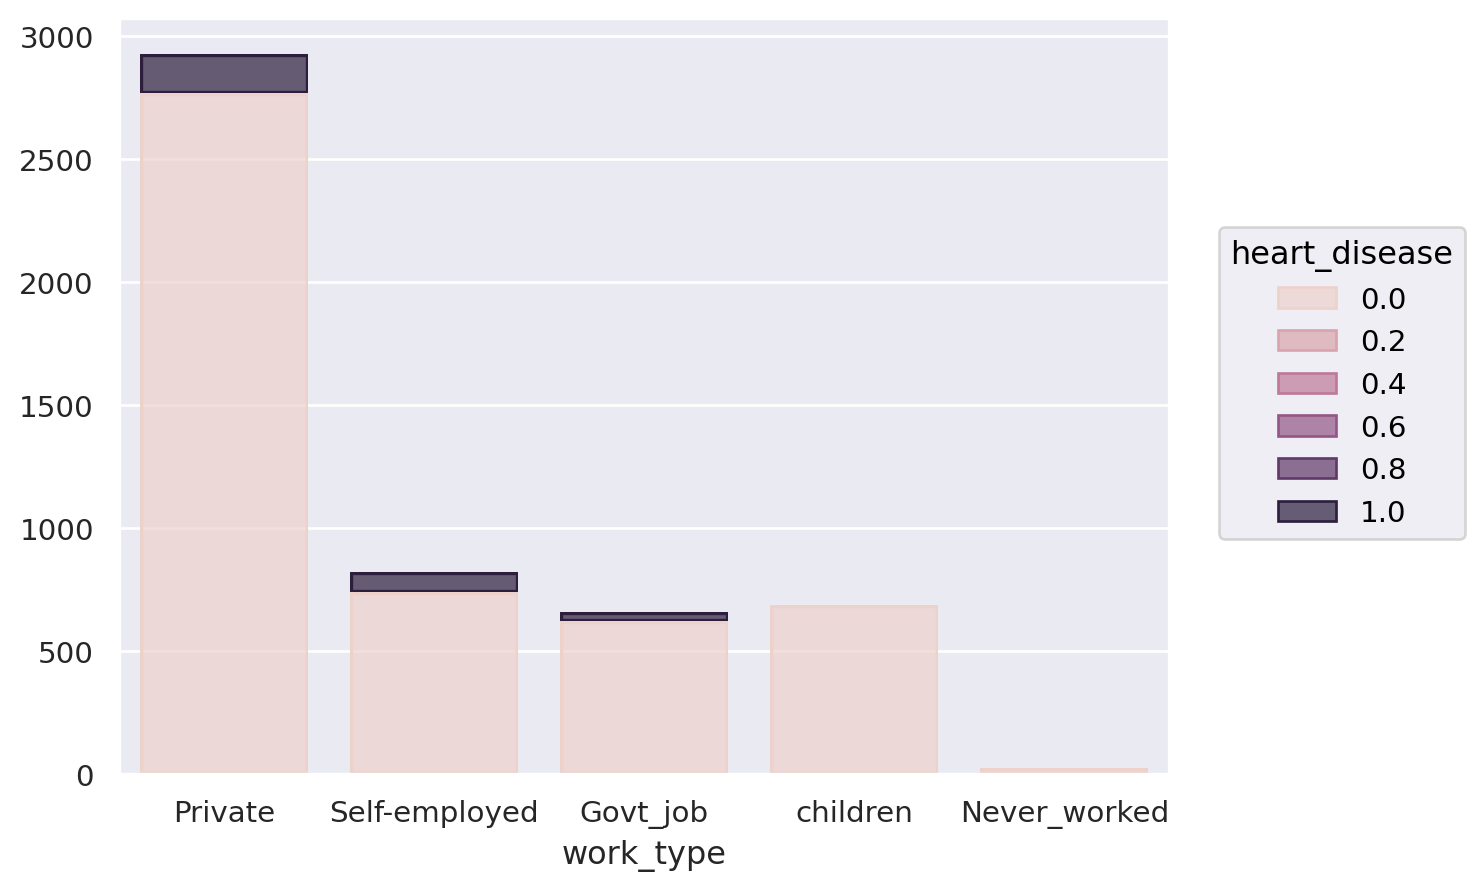

In [164]:
import seaborn.objects as so
so.Plot(df, x="work_type", color="heart_disease").add(so.Bar(), so.Count(), so.Stack())

The largest proportion of people who suffers from heart disease work in private sector.



##Analysing Residence_type
Residence_type is a binary categorical variable with values "Rural" or "Urban"

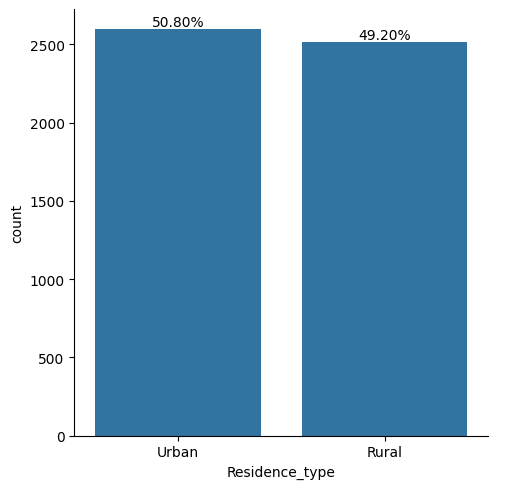

In [165]:
gender_counts = df.Residence_type.value_counts()
total = len(df)

# Create the count plot
plot = sns.catplot(data=df, x="Residence_type", kind="count")
ax = plot.ax

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

Almost half of the population lives in urban and the other half lives in rural.



Are people living in urban more prone to heart diseases?



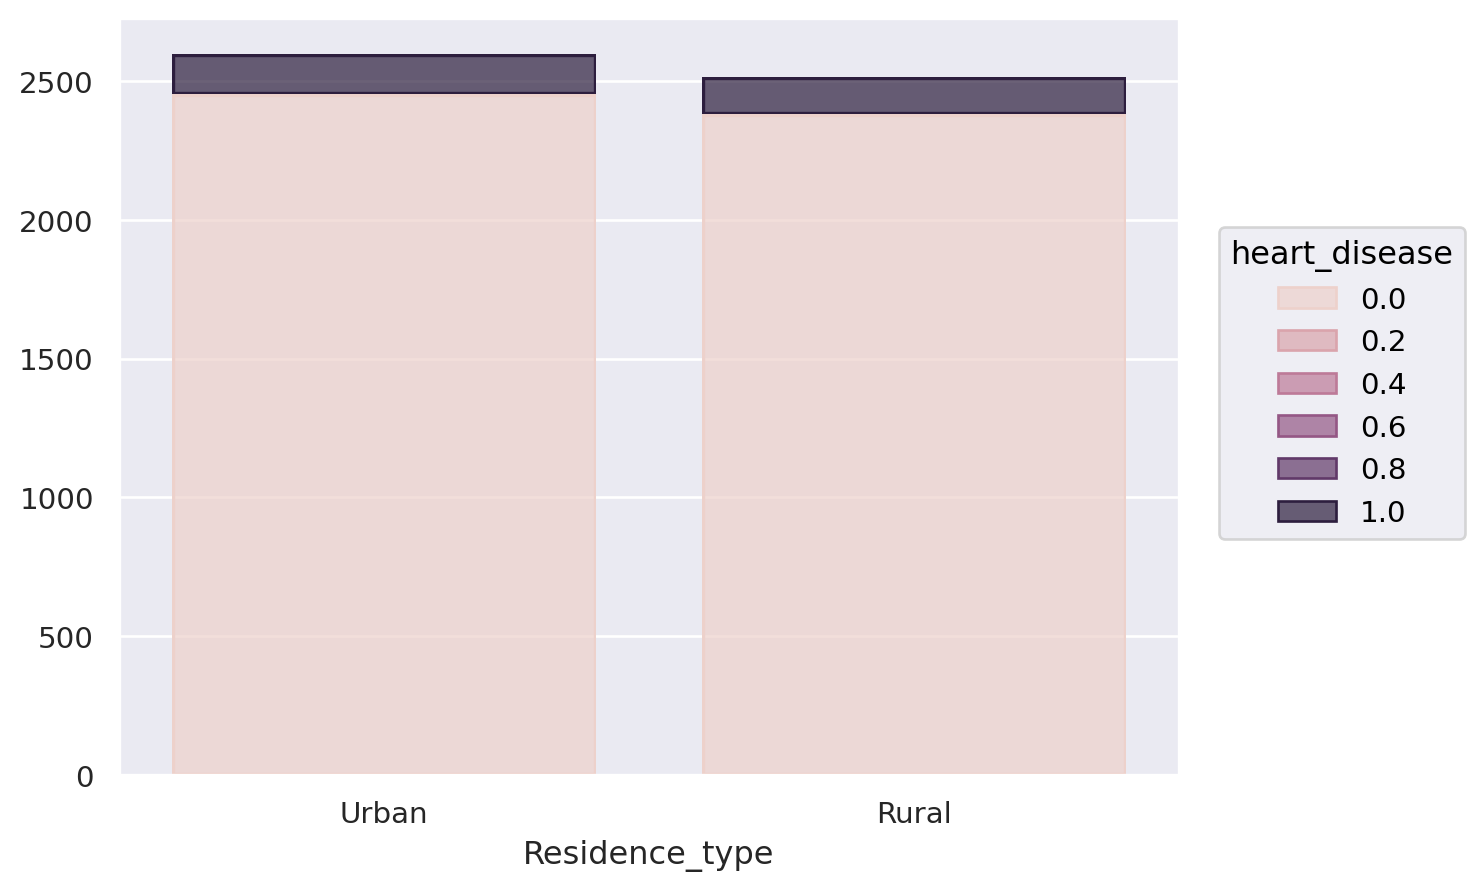

In [166]:
import seaborn.objects as so
so.Plot(df, x="Residence_type", color="heart_disease").add(so.Bar(), so.Count(), so.Stack())

From above plot we can say both Urban and Rural people are equally prone to get a heart disease.



##Analysing avg_glucose_level
avg_glucose_level is a numerical variable

Let's see if there is any relation in between avg glucose level and age



<Axes: xlabel='age', ylabel='avg_glucose_level'>

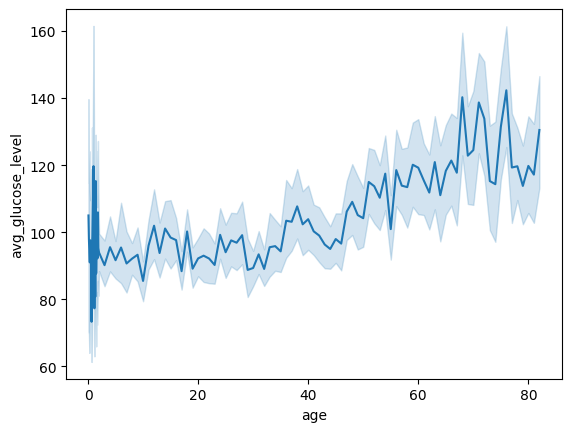

In [167]:
sns.lineplot(data=df, x="age", y="avg_glucose_level")


With age the avg glucose level also increases.



There are 627 people whose avg glucose level is more than 169.35750000000002


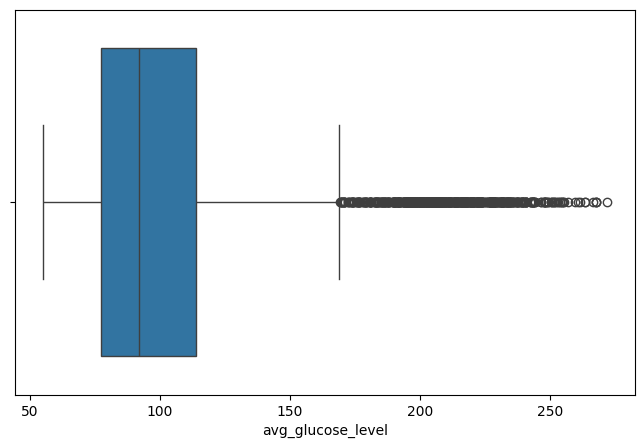

In [168]:
plt.figure(figsize = (8,5))
sns.boxplot(x = df.avg_glucose_level)
#check for outliers
IQR = df.describe().loc['75%','avg_glucose_level'] - df.describe().loc['25%','avg_glucose_level']
lower_limit = df.describe().loc['25%','avg_glucose_level'] - 1.5*IQR
higher_limit = df.describe().loc['75%','avg_glucose_level'] + 1.5*IQR
outliers = [val for val in df.avg_glucose_level if (val < lower_limit or val > higher_limit)]
print(f'There are {len(outliers)} people whose avg glucose level is more than {higher_limit}')

There is a subset of people with significantly high average glucose levels. High average glucose levels are often associated with health issues like diabetes.



In [169]:
df.groupby(by = 'heart_disease')[['avg_glucose_level']].agg(['mean', 'median'])

avg_glucose_level         
                           mean   median
heart_disease                           
0                    104.396494   91.265
1                    136.818768  106.545

People who suffers from heart disease have more mean avg glucose level.



##Analysing Bmi
bmi is a numerical variable

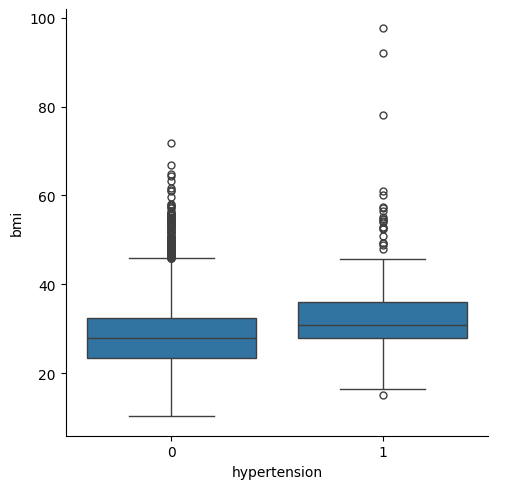

In [170]:
sns.catplot(data=df, x="hypertension", y="bmi", kind="box")

The median value of bmi is higher in people having hypertension than those who don't have hypertension.



##Analysing smoking_status
smoking_status is a categorical vaariable with values "formerly smoked", "never smoked", "smokes" or "Unknown"

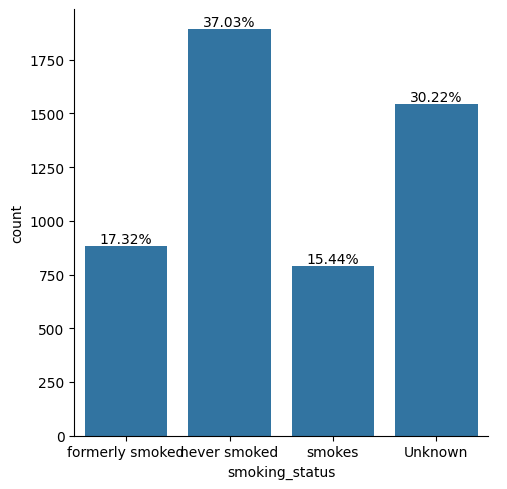

In [171]:
gender_counts = df.smoking_status.value_counts()
total = len(df)

# Create the count plot
plot = sns.catplot(data=df, x="smoking_status", kind="count")
ax = plot.ax

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

Let's see if there is any relation in between smoking_status and heart_disease



                 heart_disease
smoking_status                
Unknown                     48
formerly smoked             77
never smoked                90
smokes                      61


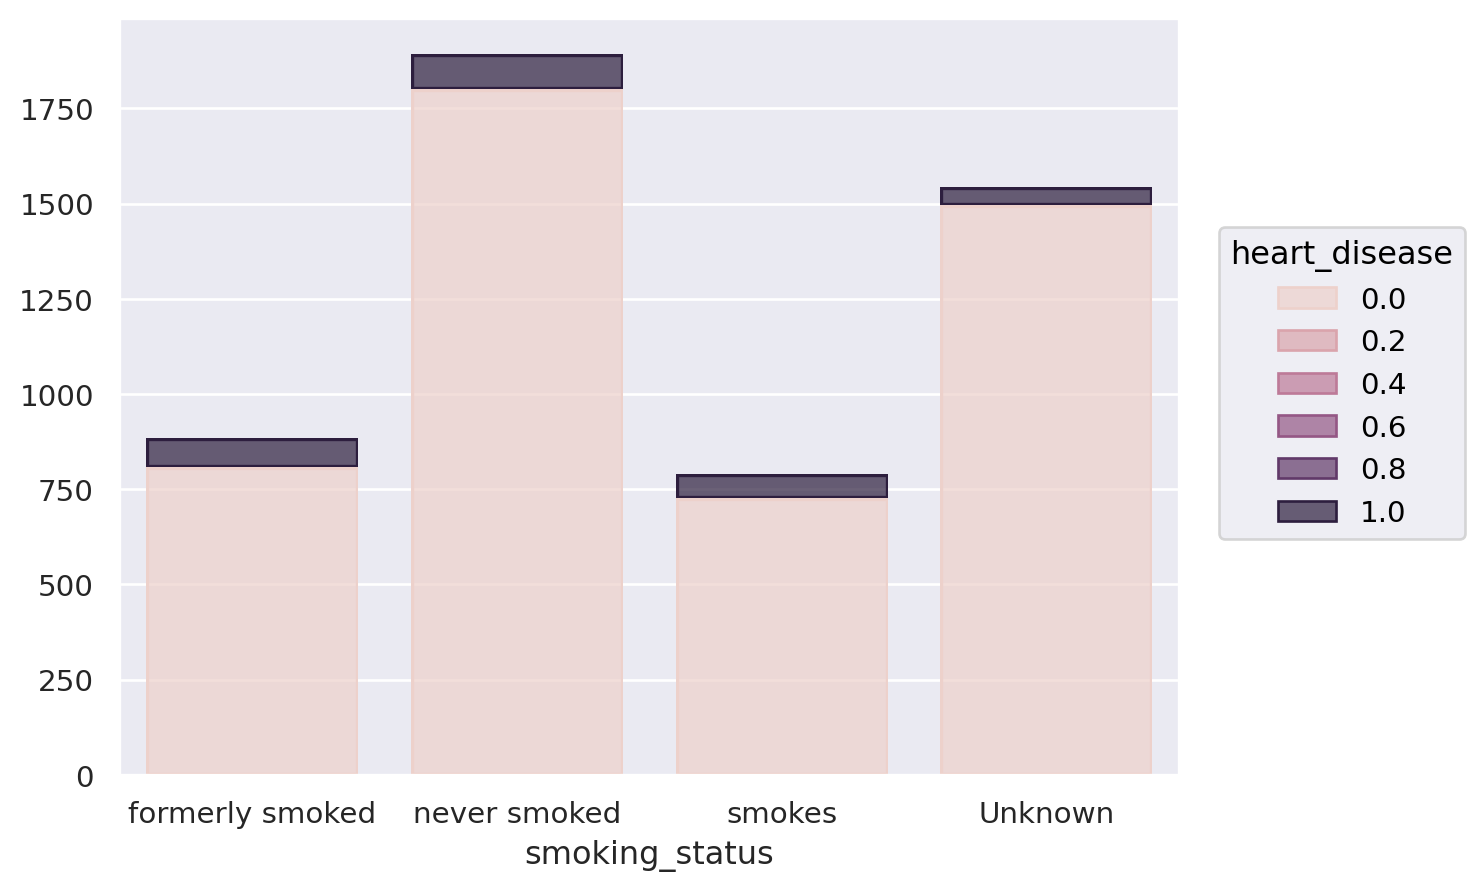

In [172]:
import seaborn.objects as so
print(df.groupby(by = 'smoking_status')[['heart_disease']].sum())
so.Plot(df, x="smoking_status", color="heart_disease").add(so.Bar(), so.Count(), so.Stack())

Largest group of people who suffers from heart disease never smoked!



                       bmi
smoking_status            
Unknown          25.762500
formerly smoked  30.603616
never smoked     29.942759
smokes           30.382510


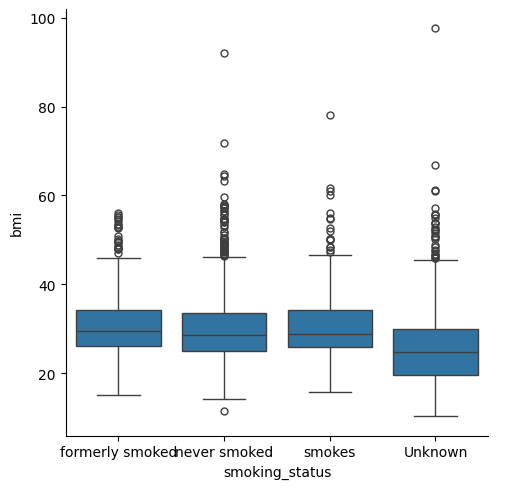

In [173]:
print(df.groupby(by = 'smoking_status')[['bmi']].mean())
sns.catplot(data=df, x="smoking_status", y="bmi", kind="box")

The average bmi of people who never smoked is slightly less than the average bmi of people who either formerly smoked or currently smokes.



##Analysing stroke
smoking_status is a categorical variable with values "formerly smoked", "never smoked", "smokes" or "Unknown"*

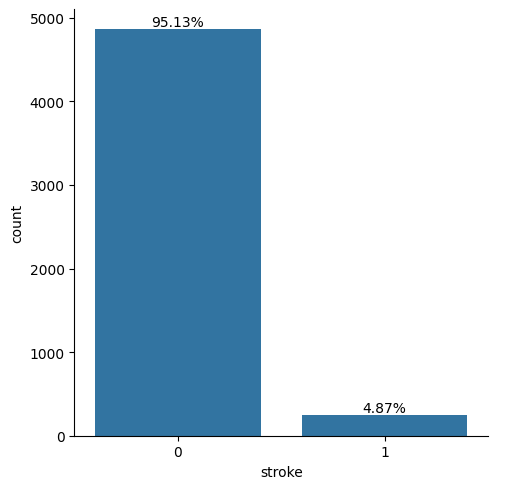

In [174]:
stroke_counts = df.stroke.value_counts()
total = len(df)

# Create the count plot
plot = sns.catplot(data=df, x="stroke", kind="count")
ax = plot.ax

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

The target variable "stroke" is highly unbalanced with almost 95:5 non-stroke:stroke ratio.



Are males more prone to strokes?



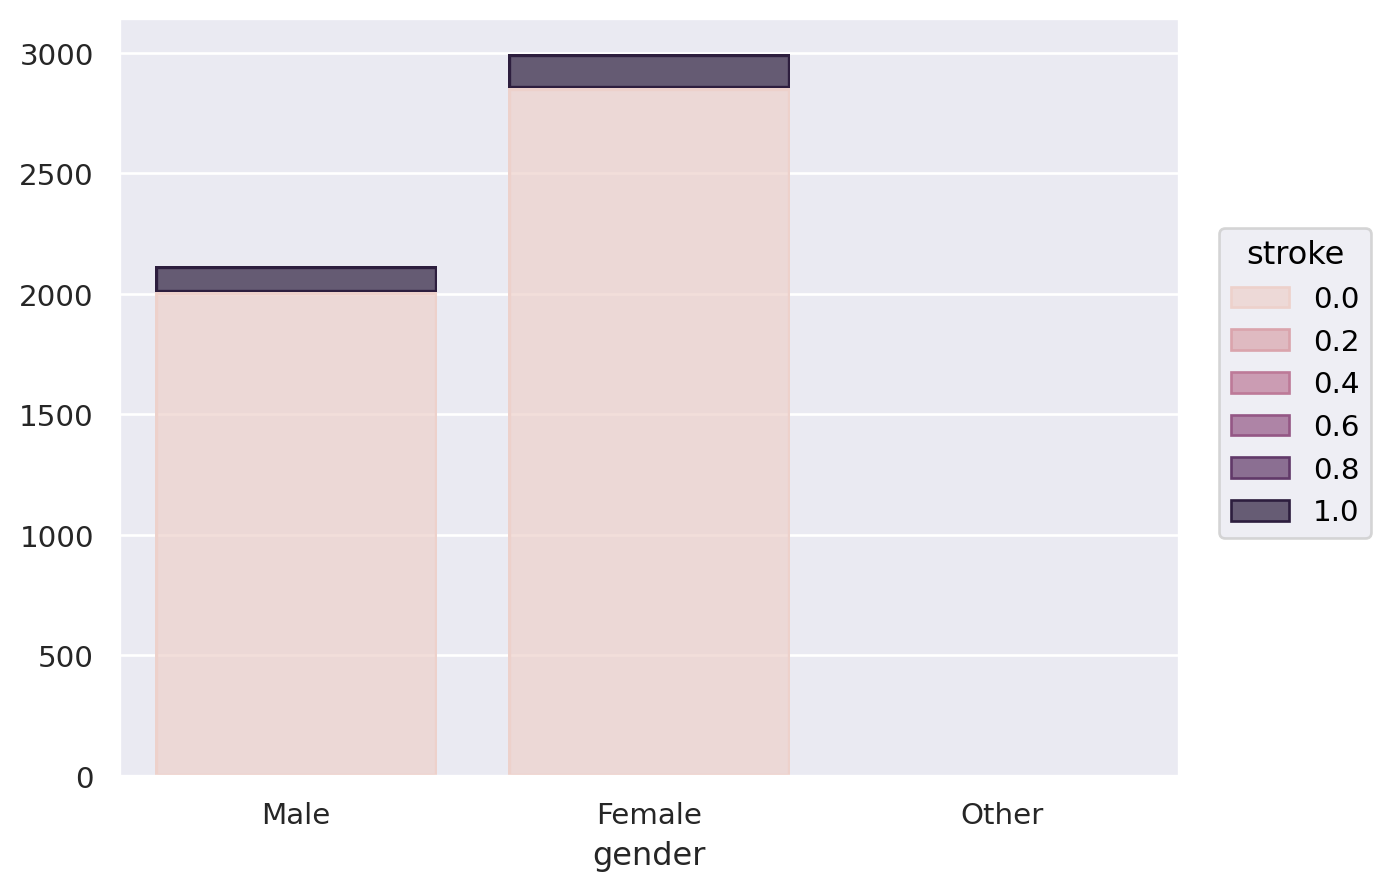

In [175]:
so.Plot(df, x="gender", color="stroke").add(so.Bar(), so.Count(), so.Stack())

From above analysis we conclude that number of females who suffer from strokes are more than the number of males who suffer from strokes. But as we can also see that the number of females are higher than the number of males in the dataset. So now lets see the percentage of males and females who suffer from strokes



In [176]:
print(df.groupby(by = 'gender')[['stroke']].sum()/df.groupby(by = 'gender')[['stroke']].count()*100)

          stroke
gender          
Female  4.709419
Male    5.106383
Other   0.000000


Out of all the males 5.1% of them suffer from strokes. While out of all the females 4.7% of them suffer from strokes.



Let's see the relation between age and stroke. What is the avg age of people who get stroke?



Average age of people
              age
stroke           
0       41.971545
1       67.728193


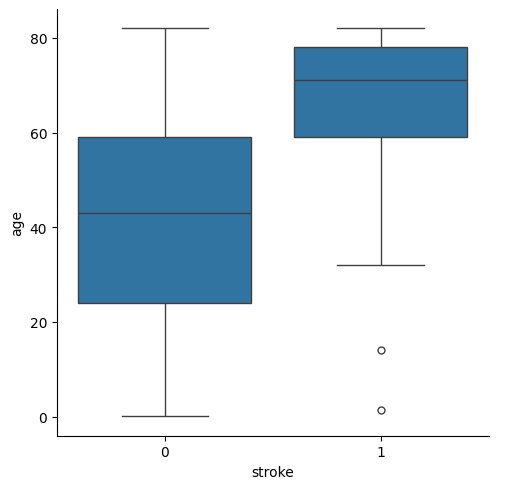

In [177]:
print("Average age of people")
print(df.groupby(by = 'stroke')[['age']].mean())
sns.catplot(data=df, x="stroke", y="age", kind="box")

Average age of people who suffer from strokes are almost 68 yrs old.



Is there any relation in between heart disease and stroke?



In [178]:
df.groupby(by = 'heart_disease')[['stroke']].sum()/df.groupby(by = 'heart_disease')[['stroke']].count()*100

,stroke
heart_disease,
0,4.178734
1,17.028986


17% of people who suffers from heart disease get stroke.



                 stroke
smoking_status         
Unknown              47
formerly smoked      70
never smoked         90
smokes               42


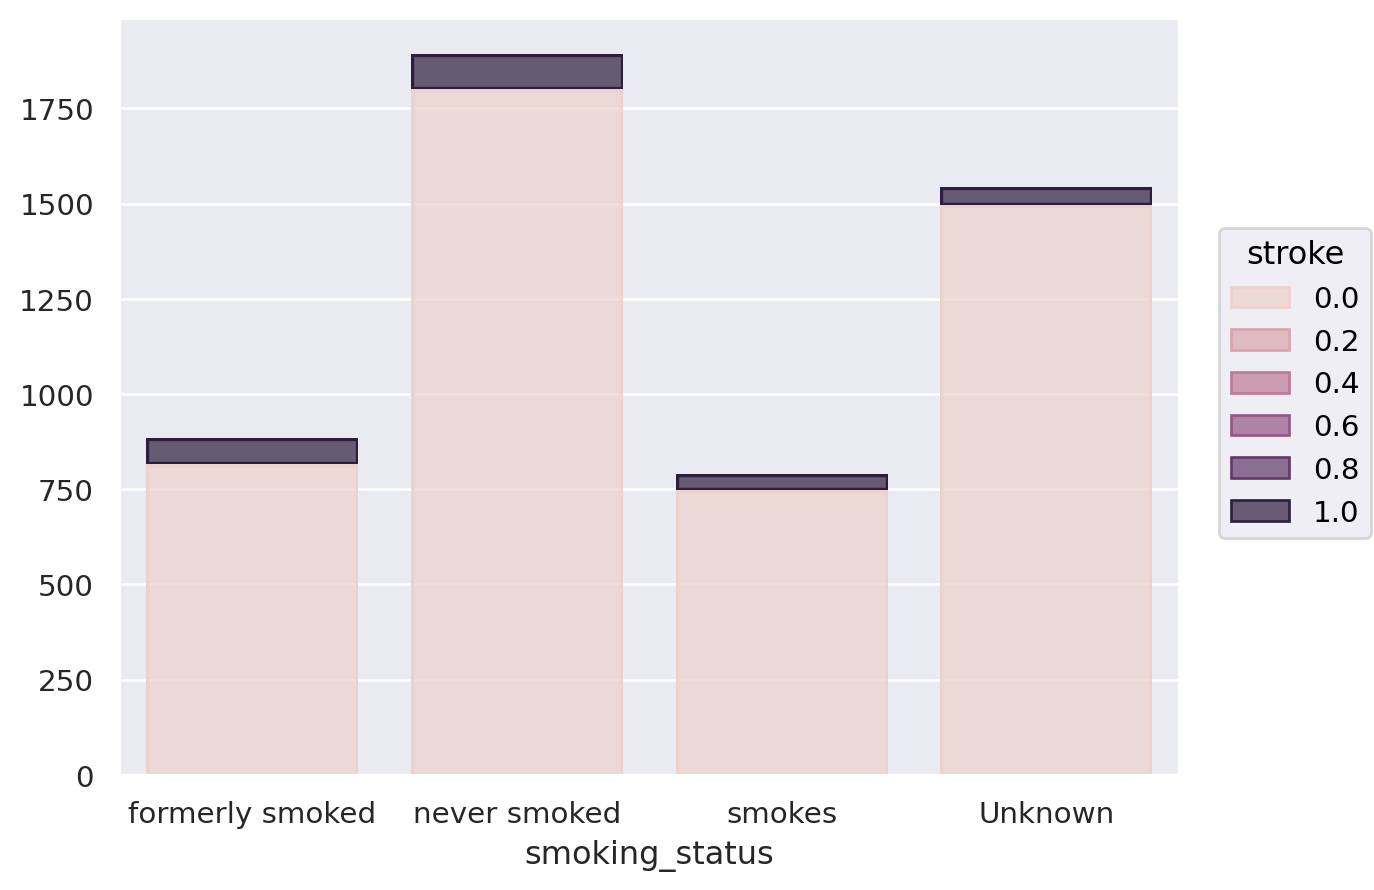

In [179]:
import seaborn.objects as so
print(df.groupby(by = 'smoking_status')[['stroke']].sum())
so.Plot(df, x="smoking_status", color="stroke").add(so.Bar(), so.Count(), so.Stack())

Large number of people who suffers from strokes never smoked!



#**5. Feature Engineering**

Let's convert categorical variables into numerical values using one hot encoding.



In [180]:
gender_dummies = pd.get_dummies(data = df.gender, drop_first=True).astype(int)
work_type_dummies = pd.get_dummies(data = df.work_type, drop_first=True).astype(int)
smoking_status_dummies = pd.get_dummies(data = df.smoking_status, drop_first=True).astype(int)
ever_married_dummies = pd.get_dummies(data = df.ever_married, drop_first=True).astype(int)
Residence_type_dummies = pd.get_dummies(data = df.Residence_type, drop_first=True).astype(int)

df = pd.concat([df, gender_dummies, work_type_dummies, smoking_status_dummies, ever_married_dummies, Residence_type_dummies], axis = 1)
df = df.drop(['gender', 'work_type', 'smoking_status', 'ever_married', 'Residence_type'] , axis = 1)

Now Normalize the dataset



In [181]:
cols = df.columns
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns = [cols])
df

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Male,Other,Never_worked,Private,Self-employed,children,formerly smoked,never smoked,smokes,Yes,Urban
0,0.816895,0.0,1.0,0.801265,0.301260,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,0.743652,0.0,0.0,0.679023,0.203895,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.975586,0.0,1.0,0.234512,0.254296,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.597168,0.0,0.0,0.536008,0.276060,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,0.963379,1.0,0.0,0.549349,0.156930,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0.975586,1.0,0.0,0.132167,0.203895,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
5106,0.987793,0.0,0.0,0.323516,0.340206,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
5107,0.426270,0.0,0.0,0.128658,0.232532,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5108,0.621582,0.0,0.0,0.513203,0.175258,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


#**6. Model Training**

In [192]:
y_new = df.stroke
X_new = df.drop('stroke', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.2, random_state = 44,shuffle=True )

print("x train shape is : ",X_train.shape)
print("x test shape is : ",X_test.shape)
print("y train shape is : ",y_train.shape)
print("y test shape is : ",y_test.shape)

x train shape is :  (4088, 16)
x test shape is :  (1022, 16)
y train shape is :  (4088, 1)
y test shape is :  (1022, 1)


In [190]:
print(X_new.shape)

(5110, 16)


Null Accuracy:

Null accuracy is used as a baseline to compare the performance of your model. If your model's accuracy is less than or equal to null accuracy, it suggests that your model is not performing better than a naive model that always predicts the most frequent class

In [183]:
y_test.value_counts()

,count
"(stroke,)",
0.0,960
1.0,62


In [184]:
null_accuracy = 960/(960+62)
null_accuracy

0.9393346379647749

Null accuracy is around 94%. Any model whose accuracy is below or equal to this would not be considered as a good model.

In [197]:
# Single Models
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', class_weight='balanced'),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced')
}

# Ensemble Models
ensemble_models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Extra Trees': ExtraTreesClassifier(),
    'Bagging': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

# Combine models for simplicity
all_models = {**models, **ensemble_models}

# Hyperparameter Grids (Example - Customize for each model)
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'Naive Bayes': {},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Decision Tree': {'max_depth': [None, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200]},
    'Extra Trees': {'n_estimators': [50, 100, 200]},
    'Bagging': {'n_estimators': [10, 20, 30]},
    'AdaBoost': {'n_estimators': [50, 100, 200]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model Evaluation and Selection
best_models = {}
results = []
confusion_matrices = {}

for name, model in all_models.items():
    grid_search = GridSearchCV(model, param_grids.get(name, {}), cv=cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else best_model.decision_function(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append({
        "Classifier": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc
    })

    # Store confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

    print(f"{name}: Best Parameters - {grid_search.best_params_}, Best Score - {grid_search.best_score_}")
    print(f"Test Accuracy: {accuracy}")

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)


Logistic Regression: Best Parameters - {'C': 10}, Best Score - 0.7384970357889948
Test Accuracy: 0.7534246575342466
KNN: Best Parameters - {'n_neighbors': 7}, Best Score - 0.9486304178026232
Test Accuracy: 0.9559686888454012
Naive Bayes: Best Parameters - {}, Best Score - 0.21794058410368905
Test Accuracy: 0.19960861056751467
SVM: Best Parameters - {'C': 10, 'kernel': 'rbf'}, Best Score - 0.7862021289648753
Test Accuracy: 0.786692759295499
Decision Tree: Best Parameters - {'max_depth': None}, Best Score - 0.9153570370459041
Test Accuracy: 0.9285714285714286
Random Forest: Best Parameters - {'n_estimators': 200}, Best Score - 0.9496084129126479
Test Accuracy: 0.9569471624266145
Extra Trees: Best Parameters - {'n_estimators': 50}, Best Score - 0.943737150347296
Test Accuracy: 0.9500978473581213
Bagging: Best Parameters - {'n_estimators': 10}, Best Score - 0.945937639344851
Test Accuracy: 0.9549902152641878
AdaBoost: Best Parameters - {'n_estimators': 50}, Best Score - 0.9454489410539484


#**7. Applying SMOTE**

The target variable "stroke" is highly imbalanced. This imbalance can lead to models that are biased towards the majority class and fail to learn the minority class well. SMOTE (Synthetic Minority Over-sampling Technique) helps by generating synthetic samples for the minority class, thus balancing the class distribution and providing the model with more representative data for both classes.



In [193]:
!pip install imbalanced-learn

In [198]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Single Models
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', class_weight='balanced'),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced')
}

# Ensemble Models
ensemble_models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Extra Trees': ExtraTreesClassifier(),
    'Bagging': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

# Combine models for simplicity
all_models = {**models, **ensemble_models}

# Hyperparameter Grids (Example - Customize for each model)
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'Naive Bayes': {},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Decision Tree': {'max_depth': [None, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200]},
    'Extra Trees': {'n_estimators': [50, 100, 200]},
    'Bagging': {'n_estimators': [10, 20, 30]},
    'AdaBoost': {'n_estimators': [50, 100, 200]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model Evaluation and Selection
best_models = {}
results = []
confusion_matrices = {}

for name, model in all_models.items():
    grid_search = GridSearchCV(model, param_grids.get(name, {}), cv=cv, scoring='accuracy')
    grid_search.fit(X_train_smote, y_train_smote)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else best_model.decision_function(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append({
        "Classifier": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc
    })

    # Store confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

    print(f"{name}: Best Parameters - {grid_search.best_params_}, Best Score - {grid_search.best_score_}")
    print(f"Test Accuracy: {accuracy}")

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)

Logistic Regression: Best Parameters - {'C': 1}, Best Score - 0.7797511965533952
Test Accuracy: 0.7495107632093934
KNN: Best Parameters - {'n_neighbors': 3}, Best Score - 0.912674670242497
Test Accuracy: 0.8454011741682974
Naive Bayes: Best Parameters - {}, Best Score - 0.5855205422162625
Test Accuracy: 0.21037181996086105
SVM: Best Parameters - {'C': 10, 'kernel': 'rbf'}, Best Score - 0.8889747811020904
Test Accuracy: 0.8424657534246576
Decision Tree: Best Parameters - {'max_depth': None}, Best Score - 0.8879453468843144
Test Accuracy: 0.8816046966731899
Random Forest: Best Parameters - {'n_estimators': 100}, Best Score - 0.9473215293313242
Test Accuracy: 0.898238747553816
Extra Trees: Best Parameters - {'n_estimators': 50}, Best Score - 0.9569817479968933
Test Accuracy: 0.8992172211350293
Bagging: Best Parameters - {'n_estimators': 30}, Best Score - 0.9305764200981141
Test Accuracy: 0.9099804305283757
AdaBoost: Best Parameters - {'n_estimators': 200}, Best Score - 0.8553571902735643
